# Image Classification of ATLAS Calorimeter Topo-Clusters (Jan)

## This is a stripped-down version of Max's re-write, so I have removed *some* functionality.

In [1]:
# If true, force re-training even if a model already exists. Existing model will be lost!
overwriteModel = False

# If true, continue training and try to train to the last specified epoch.
# If EarlyStopping was used, this may result in trying to further train a "finished" network.
finishTraining = False

# If no file extension, uses native TensorFlow format (.tf).
# If 'h5', uses HDF5. HDF5 does not work for custom layers/classes! (unless you design them a certain way)
file_extension = '.h5'
if(file_extension != '' and '.' not in file_extension):
    file_extension = '.' + file_extension

Quick Navigation:
- [Simple feed-forward Neural Network](#Simple-feed-forward-Neural-Network.)
- [ROC Curve Scans](#ROC-Curve-Scans)
- [Combination Network](#Combination-Network)

In [2]:
#import libraries and some constants
import os, sys, json, pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ROOT as rt # I will use this for some plotting
import uproot as ur

path_prefix = os.getcwd() + '/../'
plotpath = path_prefix+'classifier/Plots/'
modelpath = path_prefix+'classifier/Models/'
# %config InlineBackend.figure_format = 'svg'

if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
from util import qol_util as qu

# Custom tensorflow.keras callbacks
from util.keras.callbacks import GetCallbacks

# Classification-specific utils
from util.classification import training_util as ctu
from util.classification import plot_util as cpu
from util.classification import data_util as cdu

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

Welcome to JupyROOT 6.22/02


In [3]:
# fancy display names for each pion type
pi_latex = {
    'pi0': '\(\pi^{0}\)',
    'piplus': '\(\pi^{+}\)',
    'piminus': '\(\pi^{-}\)',
}

In [4]:
# Plotting settings

# plotting mode
mode = 'dark'

# xkcd -- turn this on for fun-looking (but marginally less useful) plots
use_xkcd = False
if(use_xkcd):
    mode = 'light'
    plt.xkcd(scale=.75,length=100,randomness=1)
    
# plotting style -- manages our color palette and object colors
plotstyle = qu.PlotStyle(mode)
    
# some matplotlib-specific stuff
params = {'legend.fontsize': 13,
          'axes.labelsize': 18}
plt.rcParams.update(params)

Now, we will import our data from the `ROOT` files into a `pandas` DataFrame. The first cell takes care of scalars, and the second takes care of vectors.

In [5]:
# import pi+- vs. pi0 images
source = 'pion' # also try 'jet'

if(source == 'pion'):
    inputpath = path_prefix+'data/pion/'
    rootfiles = ["pi0", "piplus", "piminus"]
    branches = ['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta', 'truthPhi', 'clusterIndex', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cell_dR_min', 'cluster_cell_dR_max', 'cluster_cell_dEta_min', 'cluster_cell_dEta_max', 'cluster_cell_dPhi_min', 'cluster_cell_dPhi_max', 'cluster_cell_centerCellEta', 'cluster_cell_centerCellPhi', 'cluster_cell_centerCellLayer', 'cluster_cellE_norm']
elif(source == 'jet'):
    inputpath = path_prefix+'jets/training/'
    rootfiles = ["pi0", "piplus"]
    branches = ['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta', 'truthPhi', 'clusterIndex', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_ENG_CALIB_TOT']
else:
    assert(False)

trees = {
    rfile : ur.open(inputpath+rfile+".root")['ClusterTree']
    for rfile in rootfiles
}
pdata = {
    ifile : itree.pandas.df(branches, flatten=False)
    for ifile, itree in trees.items()
}

total = 0
for key in rootfiles:
    total += len(pdata[key])

for key in rootfiles:
    n = len(pdata[key])
    print("Number of {a:<7} events: {b:>10}\t({c:.1f}%)".format(a=key, b = n, c = 100. * n / total))
print("Total: {}".format(total))

Number of pi0     events:     264167	(23.2%)
Number of piplus  events:     436949	(38.4%)
Number of piminus events:     436802	(38.4%)
Total: 1137918


The number of events for each category may be quite different -- ultimately we want to train our classifier on a "balanced" dataset, where we have equal numbers of entries from each category.

We're training our network to classify between $\pi^\pm$ and $\pi^0$ events. Thus, we should ultimately merge our $\pi^+$ and $\pi^-$ data.

Thus, we will first generate selected indices for all categories, such that the total number of events from each category is equal, and *then* we will merge things.

Note that as we're dealing with DataFrames (`pdata`) and uproot trees (`trees`, whose contents get loaded into `pcells`), we have to be careful that when we merge data, we do it the same way for both sets of objects. Otherwise we might scramble our $\pi^\pm$ data.

In [6]:
n_indices = {}
n_max = int(np.min(np.array([len(pdata[key]) for key in trees.keys()])))
rng = np.random.default_rng()

# If we have a piminus key, assume the dataset are piplus, piminus, pi0
if('piminus' in trees.keys()):
    n_indices['piplus']  = int(np.ceil((n_max / 2)))
    n_indices['piminus'] = int(np.floor((n_max / 2)))
    n_indices['pi0']     = n_max
    
# Otherwise, assume we already have piplus (or piplus + piminus) and pi0, no merging needed
else: n_indices = {key:n_max for key in trees.keys}
indices = {key:rng.choice(len(pdata[key]), n_indices[key], replace=False) for key in trees.keys()}

# Make a boolean array version of our indices, since pandas is weird and doesn't handle non-bool indices?
bool_indices = {}
for key in pdata.keys():
    bool_indices[key] = np.full(len(pdata[key]), False)
    bool_indices[key][indices[key]] = True

# Apply the (bool) indices to pdata
for key in trees.keys():
    pdata[key] = pdata[key][bool_indices[key]]

# prepare pcells -- immediately apply our selected indices
pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, indices = indices[ifile])
        for layer in layers
    }
    for ifile, itree in trees.items()
}

In [7]:
# Now with the data extracted from the trees into pcells, we merge pdata and pcells as needed.
# Note the order in which we concatenate things: piplus -> piplus + piminus.
if('piminus' in trees.keys()):
    print('Merging piplus and piminus.')
    
    # merge pdata
    pdata['piplus'] = pdata['piplus'].append(pdata['piminus'])
    del pdata['piminus']
    
    # merge contents of pcells
    for layer in layers:
        pcells['piplus'][layer] = np.row_stack((pcells['piplus'][layer],pcells['piminus'][layer]))
    del pcells['piminus']

Merging piplus and piminus.


In [8]:
pdata_merged, pcells_merged, plabels = cdu.DataPrep(pdata, pcells, layers, trainfrac=0.7)

We'll train the network on $\pi^+$ and $\pi^0$ events.

### Plot a few example images.

These are the images that we will use to train our network (together with a few other variables).

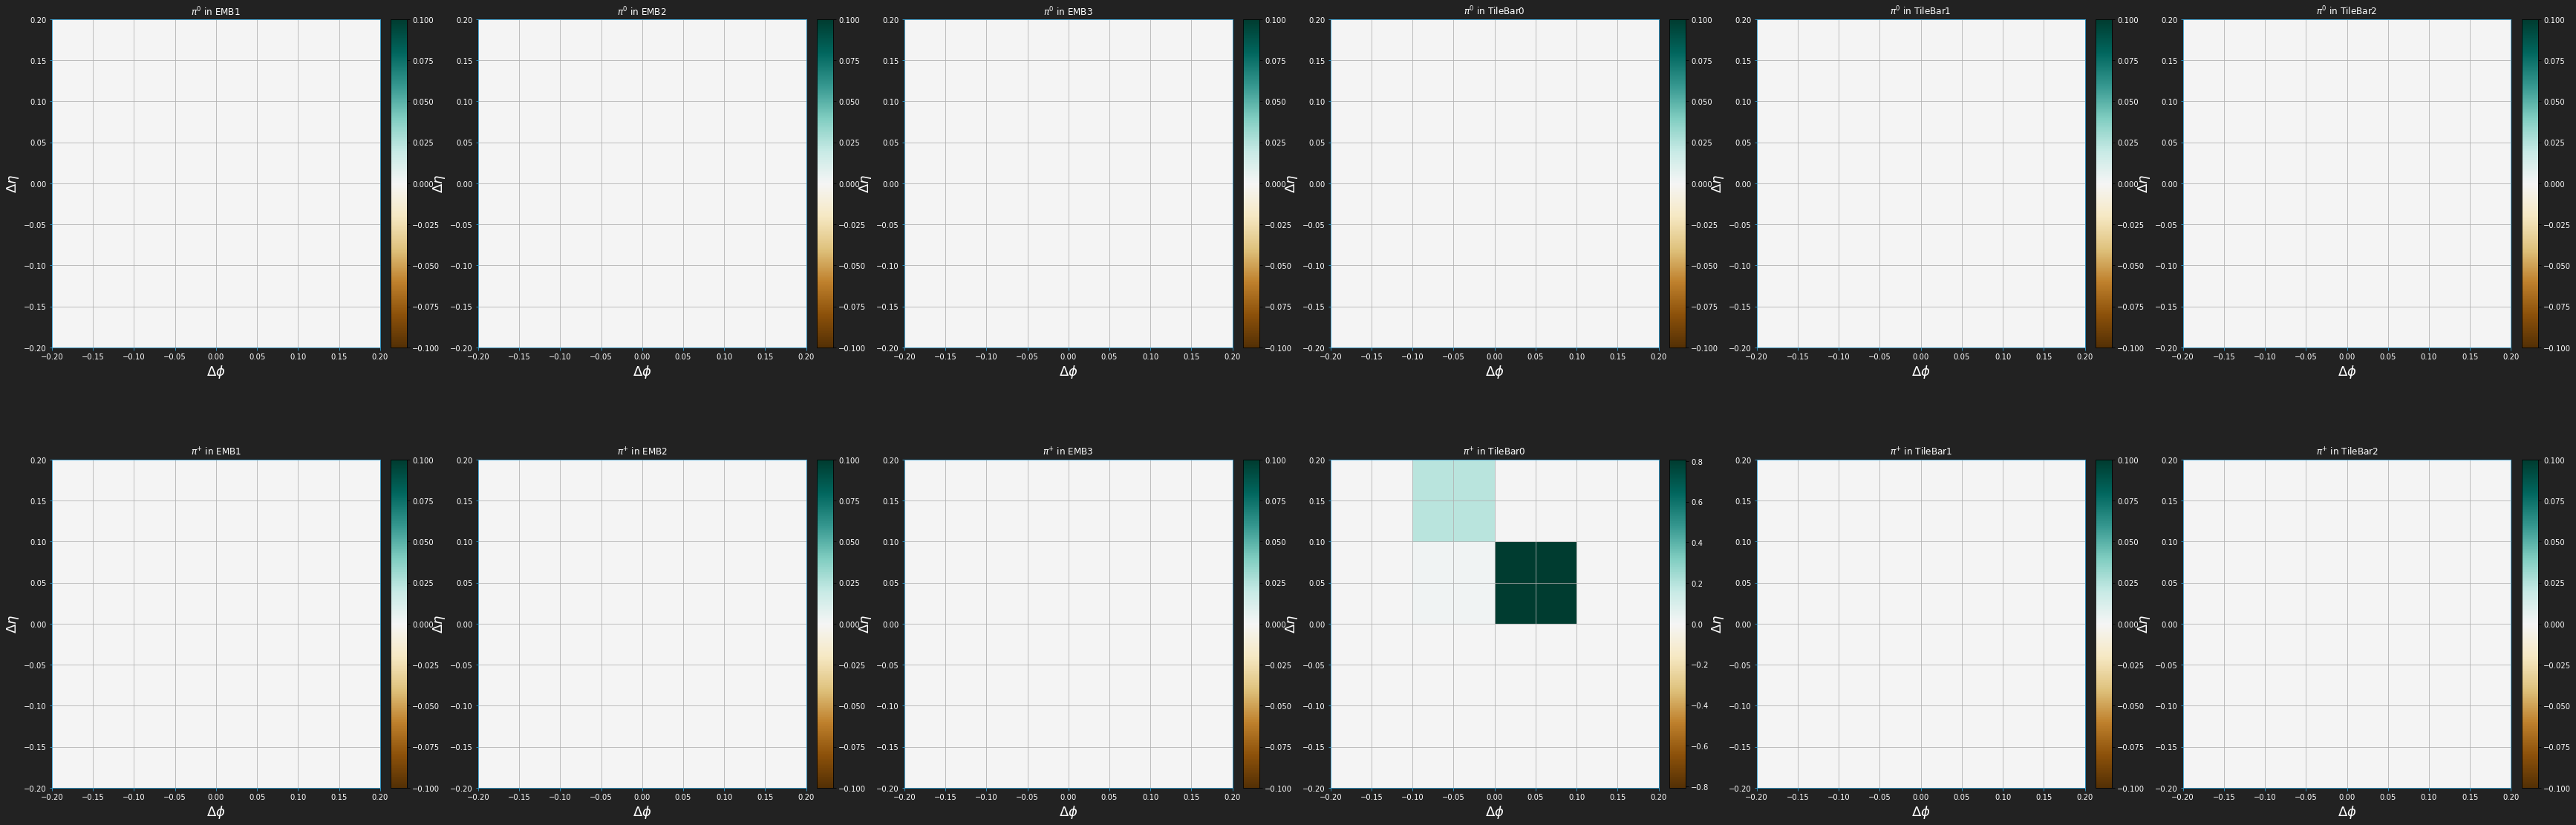

In [9]:
cpu.ImagePlot(
    pcells,
    cluster=100,
    layers=layers,
    cell_shapes=cell_shapes,
    plotpath=plotpath,
    plotstyle=plotstyle
)

### Plot a few histograms.

These are a bit uglier than the `matplotlib` ones Max made, but it's perhaps even easier to see any differences between $\pi^\pm$ and $\pi^0$.

Info in <TCanvas::Print>: pdf file /local/home/jano/ml4pions/LCStudies/classifier/../classifier/Plots/hist_pi0_plus_minus.pdf has been created


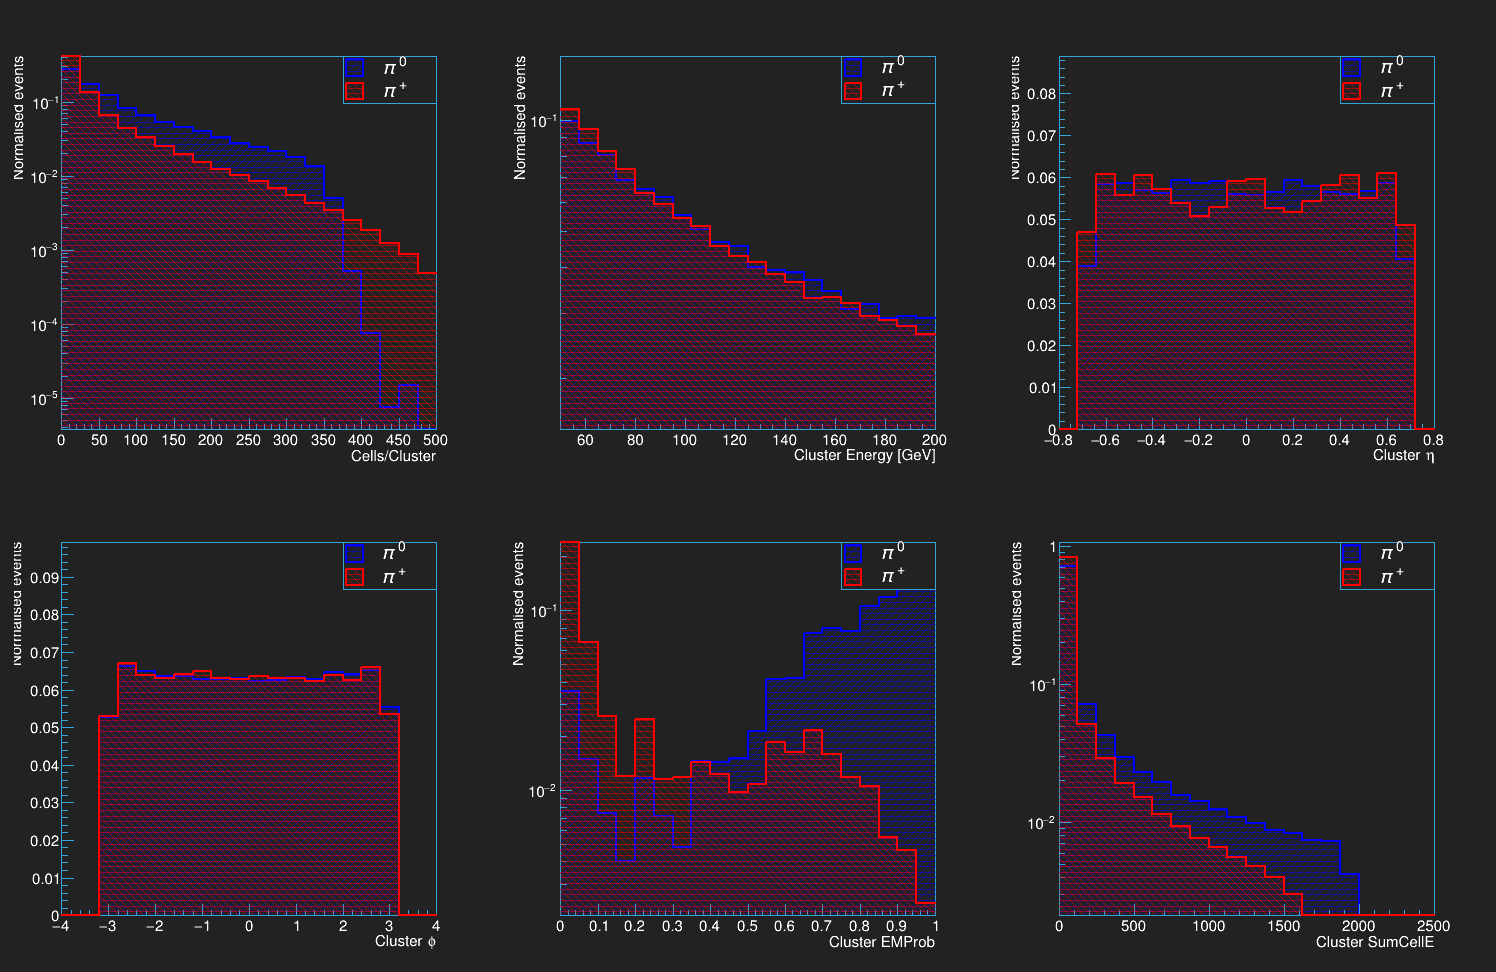

In [10]:
rt.gStyle.SetOptStat(0)

plotstyle.SetStyle()

# For storing histograms and legends, to prevent overwriting. (TODO: Probably better ways to do this in PyROOT)
histos = []
legends = []

qtys = ['cluster_nCells', 'clusterE', 'clusterEta', 'clusterPhi', 'cluster_EM_PROBABILITY', 'cluster_sumCellE']
qty_labels = ['Cells/Cluster', 'Cluster Energy [GeV]', 'Cluster #eta', 'Cluster #phi', 'Cluster EMProb', 'Cluster SumCellE']
qty_ranges = [(0,500), (50,200), (-0.8,0.8), (-4.,4.), (0.,1.), (0.,2500.)]

if(source == 'jet'):
    qtys = ['cluster_nCells', 'clusterE', 'clusterEta', 'clusterPhi']
    qty_labels = ['Cells/Cluster', 'Cluster Energy [GeV]', 'Cluster #eta', 'Cluster #phi']
    qty_ranges = [(0,300), (0,100), (-0.8,0.8), (-4.,4.)]

# Set up a canvas.
plot_size = 500
nx = int(np.ceil(len(qtys) / 2))
ny = 2
n_pad = nx * ny
canvas = rt.TCanvas('cluster_hists','c1',plot_size * nx,plot_size * ny)
canvas.Divide(nx,ny)

colors = {'piplus':rt.kRed,'pi0':rt.kBlue}
styles = {'piplus':3440, 'pi0':3404}

n_bins=20
for i, (qty, label, rng) in enumerate(zip(qtys, qty_labels, qty_ranges)):
    canvas.cd(i+1)
    leg = rt.TLegend(0.7,0.8,0.9,0.9)
    for ptype, p in pdata.items():
        hist = rt.TH1F('h_'+str(ptype)+'_'+str(qty),'',n_bins,rng[0],rng[1])
        for entry in p[qty]: hist.Fill(entry)
        integral = hist.Integral()
        if(integral != 0): hist.Scale(1./hist.Integral())
        hist.SetLineColor(colors[ptype])
        hist.SetLineWidth(2)
        hist.SetFillColorAlpha(colors[ptype],0.5)
        hist.SetFillStyle(styles[ptype])
        hist.Draw('HIST SAME')
        hist.GetXaxis().SetTitle(label)
        hist.GetYaxis().SetTitle('Normalised events')
        hist.SetMaximum(1.5 * hist.GetMaximum())
        leg.AddEntry(hist,pi_latex[ptype],'f')
        leg.Draw()
        histos.append(hist)
        legends.append(leg)
    if(qty in ['cluster_nCells','clusterE', 'cluster_EM_PROBABILITY', 'cluster_sumCellE']): rt.gPad.SetLogy()
canvas.Draw()
canvas.SaveAs(plotpath+'hist_pi0_plus_minus.pdf')

## TensorFlow/Keras prep

In [11]:
ngpu = 1
gpu_list = ["/gpu:"+str(i) for i in range(ngpu)]
#gpu_list = ["/gpu:0"] #["/gpu:0","/gpu:1","/gpu:2","/gpu:3"]

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disable some of the tensorflow info printouts, only display errors
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))
from util.classification.models import baseline_nn_model, simple_combine_model, resnet

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


Let's prepare some callbacks (originally from our regression notebook).

In [12]:
# For storing models and some of their metrics (acc, loss)
models = {}
model_history = {}
model_scores = {}
model_performance = {}

# For storing info on ROC curves
roc_fpr = {}
roc_tpr = {}
roc_thresh = {}
roc_auc = {}

Let's add some info to our dictionaries that corresponds to the existing `EM LC Prob` method.

In [13]:
model_key = 'LC EMProb'
model_scores[model_key] = 1-pdata_merged["cluster_EM_PROBABILITY"]
cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    drawPlots=False
)

Area under curve for LC EMProb: 0.9381771421693221


## Simple feed-forward Neural Network.
<div style="text-align: right"> <a href="#Image-Classification-of-ATLAS-Calorimeter-Topo-Clusters-Rewrite">Top</a> </div>

First, we're going to train simple, feed-foward neural networks -- one per calo layer. These will be our "baseline networks".

Note that while for most of the notebook, we'll train one instance of a network per model, whereas here we will explicitly train multiple instances as we're doing one instance *per calo layer*, each for the same model.

In [14]:
lr = 5e-5
gamma = 0.1
min_delta = 0.0001
patience = 3
dropout = 0.1 # < 0 -> no dropout
#model = baseline_nn_model(strategy, lr=lr, dropout=dropout)

nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts

model_name = 'flat'
model_dir = modelpath + model_name # directory for loading/saving flat models

for layer in layers:
    
    model_key = '{}_{}'.format(model_name, layer)
    modelfile = '{}/{}{}'.format(model_dir,model_key, file_extension)
    npix = cell_shapes[layer][0] * cell_shapes[layer][1]
    models[model_key] = baseline_nn_model(strategy, npix, lr=lr, dropout=dropout)
    
    # train the network
    models[model_key], model_history[model_key] = ctu.TrainNetwork(
        model=models[model_key], 
        modelfile=modelfile, 
        x_train = pcells_merged[layer][pdata_merged.train], 
        y_train = plabels[pdata_merged.train], 
        x_valid = pcells_merged[layer][pdata_merged.val], 
        y_valid = plabels[pdata_merged.val], 
        callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
        epochs=nepochs, 
        batch_size=batch_size, 
        verbose=verbose, 
        overwriteModel=overwriteModel,
        finishTraining=finishTraining
    )
        
    # get performance metric from test set
    model_performance[model_key] = models[model_key].evaluate(
        pcells_merged[layer][pdata_merged.test],
        plabels[pdata_merged.test],
        verbose=0
    )
    
    print('Finished layer {}.'.format(layer))
    
    # get/recalculate network scores for the dataset
    model_scores[model_key] = models[model_key].predict(pcells_merged[layer])[:,1]

Finished layer EMB1.
Finished layer EMB2.
Finished layer EMB3.
Finished layer TileBar0.
Finished layer TileBar1.
Finished layer TileBar2.


Let's look at accuracy and loss, as well as ROC curves, for each network.

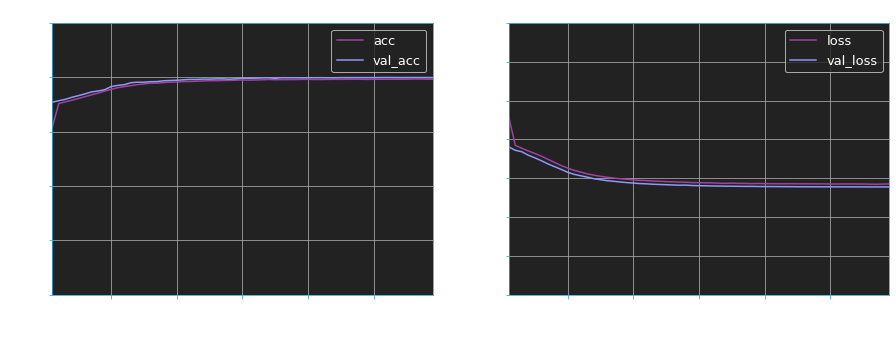

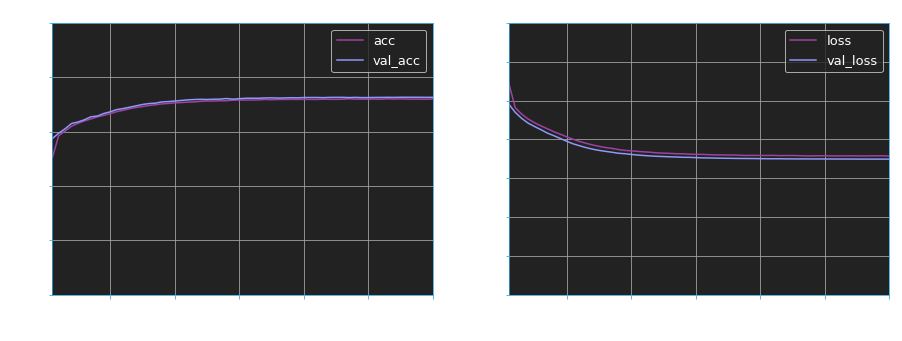

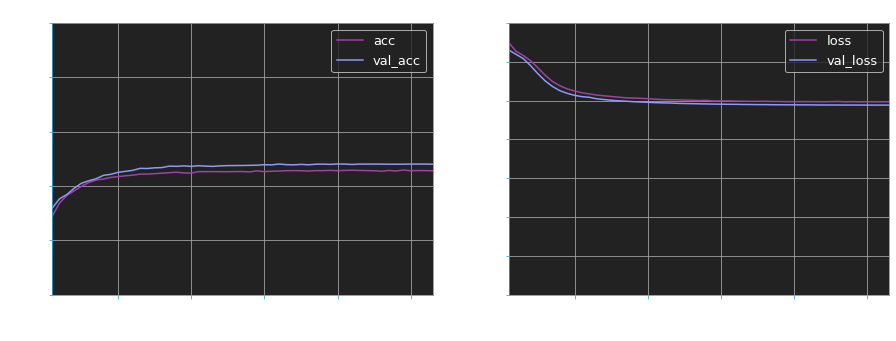

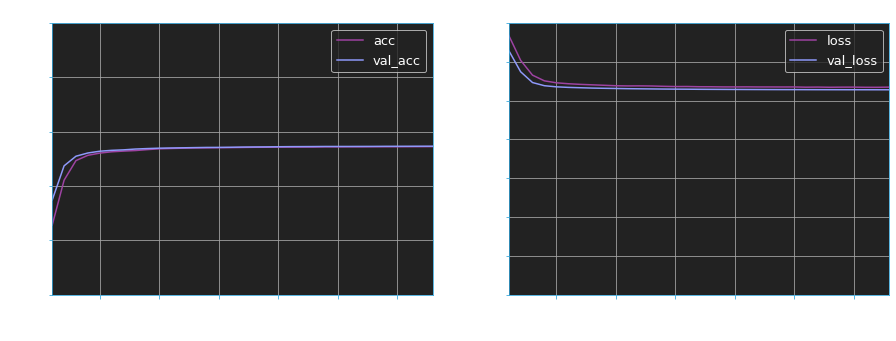

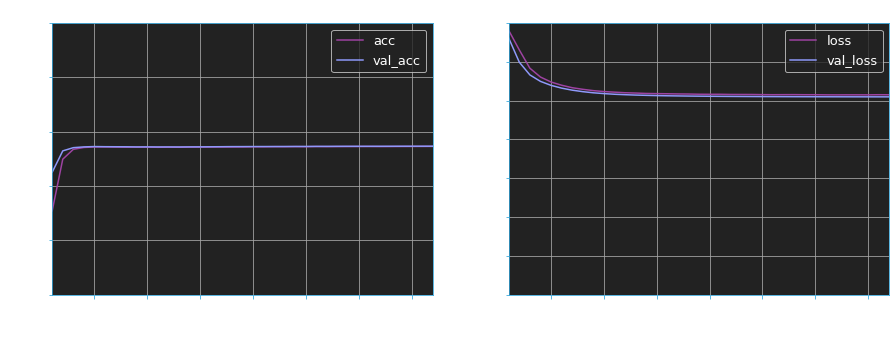

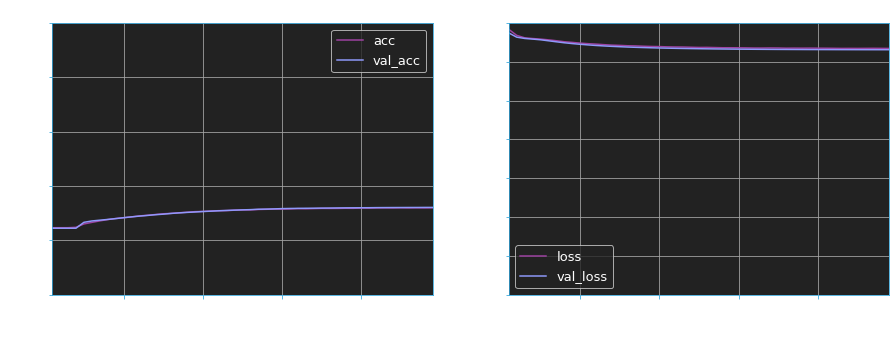

Area under curve for LC EMProb: 0.9381771421693221
Area under curve for flat_EMB1: 0.9418724385628977
Area under curve for flat_EMB2: 0.913181263027615
Area under curve for flat_EMB3: 0.8130706504609365
Area under curve for flat_TileBar0: 0.6684520870500169
Area under curve for flat_TileBar1: 0.7188261913200858
Area under curve for flat_TileBar2: 0.637419195641959


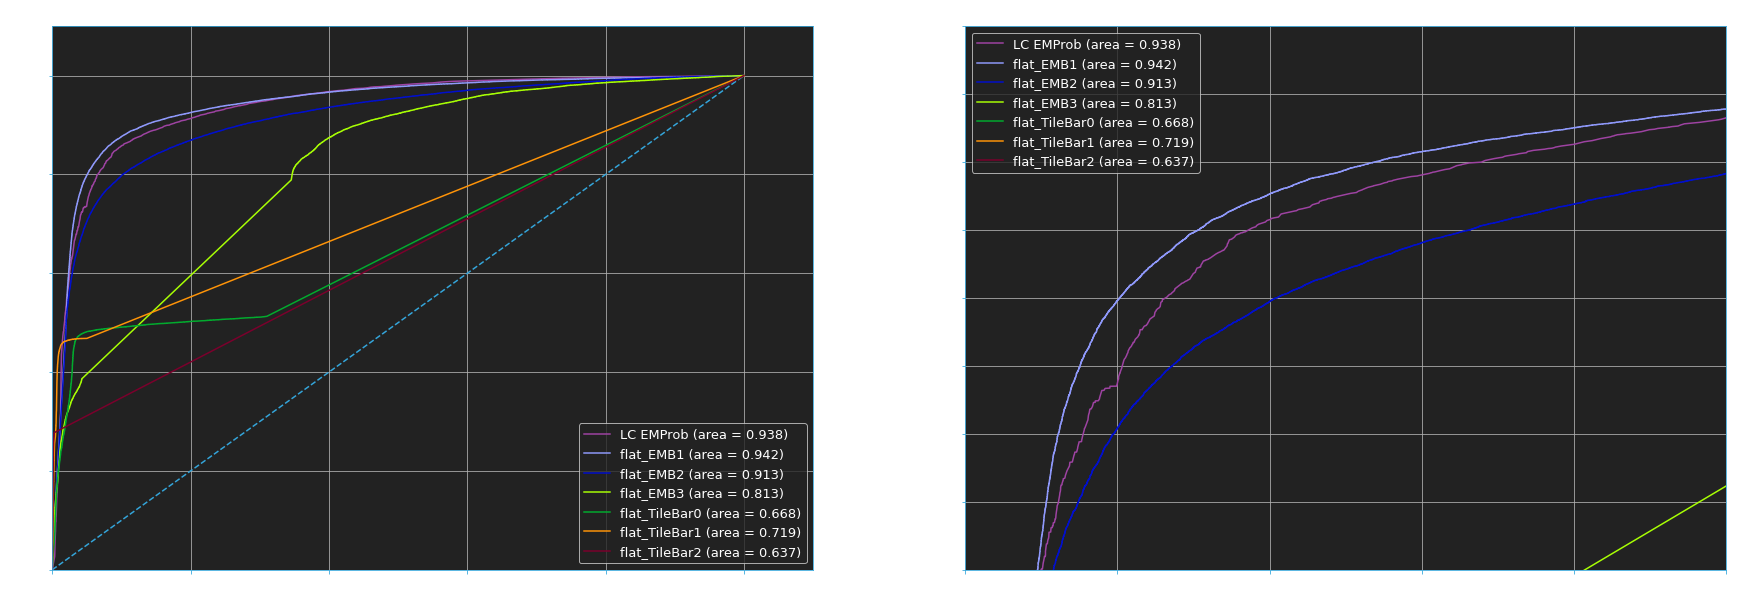

In [15]:
cpu.MetricPlot(
    model_history,
    plotpath=plotpath,
    plotstyle=plotstyle
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_flat',
    drawPlots=True,
    plotstyle=plotstyle,
    figsize=(30,10)
)

## Combination Network
<div style="text-align: right"> <a href="#Image-Classification-of-ATLAS-Calorimeter-Topo-Clusters-Rewrite">Top</a> </div>

Here we train a simple combination network. Its inputs will be the *outputs* of our simple, feed-forward neural networks from above.

In [16]:
model_name = 'simple'
model_dir = modelpath + model_name # directory for loading/saving simple combination network
model_key = 'simpleCombine'

model_scores_stack = np.column_stack( [model_scores['flat_{}'.format(layer)] for layer in layers])
n_input = model_scores_stack.shape[1]

lr = 1e-3
gamma = 0.1
min_delta = 0.0005
patience = 5

nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts
    
modelfile = '{}/{}{}'.format(model_dir,model_key,file_extension)
models[model_key] = simple_combine_model(strategy, lr=lr, n_input=n_input)
    
# train the network
models[model_key], model_history[model_key] = ctu.TrainNetwork(
    model=models[model_key], 
    modelfile=modelfile, 
    x_train = model_scores_stack[pdata_merged.train],
    y_train = plabels[pdata_merged.train], 
    x_valid = model_scores_stack[pdata_merged.val], 
    y_valid = plabels[pdata_merged.val], 
    callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
    epochs=nepochs, 
    batch_size=batch_size, 
    verbose=verbose, 
    overwriteModel=overwriteModel,
    finishTraining=finishTraining
)
        
# get performance metric from test set
model_performance[model_key] = models[model_key].evaluate(
    model_scores_stack[pdata_merged.test],
    plabels[pdata_merged.test],
    verbose=0
)
    
# get/recalculate network scores for the dataset
model_scores[model_key] = models[model_key].predict(model_scores_stack)[:,1]

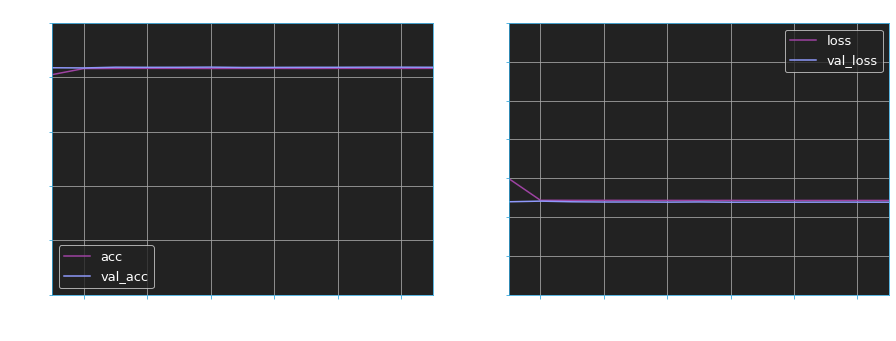

Area under curve for LC EMProb: 0.9381771421693221
Area under curve for flat_EMB1: 0.9418724385628977
Area under curve for simpleCombine: 0.9589334090791628


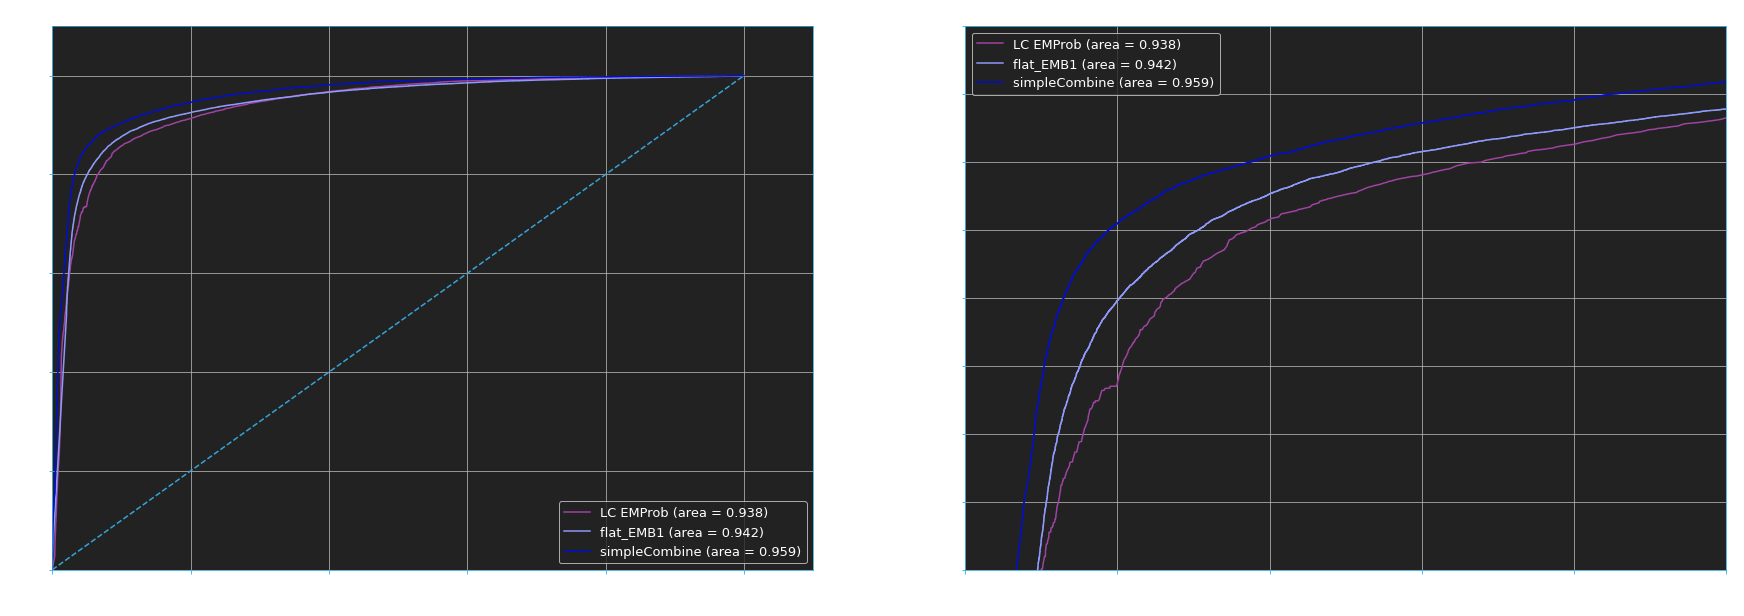

In [17]:
cpu.MetricPlot(
    model_history,
    plotpath=plotpath,
    model_keys = ['simpleCombine'],
    plotstyle=plotstyle
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_simple',
    drawPlots=True,
    plotstyle=plotstyle,
    figsize=(30,10),
    model_keys = ['LC EMProb', 'flat_EMB1', 'simpleCombine']
)

## ResNet

In [18]:
# minor data prep -- key names match those defined within resnet model in models.py!
pcells_merged_unflattened = {'input' + str(i):pcells_merged[key].reshape(tuple([-1] + list(cell_shapes[key]))) for i,key in enumerate(pcells_merged.keys())}

rn_train = {key:val[pdata_merged.train] for key,val in pcells_merged_unflattened.items()}
rn_valid = {key:val[pdata_merged.val] for key,val in pcells_merged_unflattened.items()}
rn_test = {key:val[pdata_merged.test] for key,val in pcells_merged_unflattened.items()}

We can also train an instance of ResNet.

To do this, we will want to appropriately up/downscale all of our calorimeter images, so they are all of the same dimensions.

In [19]:
for key, val in cell_shapes.items():
    print(key,val)

EMB1 (128, 4)
EMB2 (16, 16)
EMB3 (8, 16)
TileBar0 (4, 4)
TileBar1 (4, 4)
TileBar2 (2, 4)


Based on the above, it seems like a reasonable choice would be rescaling all images to be of shape `(128,16)`. That corresponds with the maximum dimensions along each axis, so we'll just need to do some upscaling. The nice thing of avoiding downscaling is that we are not losing information.

We can run a quick test to make sure that our scaling is working as expected.

In [20]:
image_test=False

from util.keras.layers import ImageScaleBlock
def TestImage(idxs):
    images = [np.stack([rn_train['input{}'.format(x)][idx,:,:] for idx in idxs],axis=0) for x in range(6)]    
    # need to add the last dimension, corresponding with channel (will be of size 1)
    images = [np.expand_dims(im, axis=-1) for im in images]
    return images

if(image_test):
    test_idx = np.arange(5)
    image = TestImage(test_idx)
    scaled_image = ImageScaleBlock((128,16),normalization=True)(image).numpy()
    for i,im in enumerate(image):
        integrals_old = np.sum(im,axis=(1,2)).flatten()
        integrals_new = np.sum(scaled_image[:,:,:,i], axis=(1,2)).flatten()

        ratio = integrals_old.copy()
        ratio[ratio==0.] = 1.
        ratio = integrals_new/ratio

        integrals_old = '\t\t'.join(['{:.1e}'.format(x) for x in integrals_old])
        integrals_new = '\t\t'.join(['{:.1e}'.format(x) for x in integrals_new])
        ratio         = '\t\t'.join(['{:.1e}'.format(x) for x in ratio        ])

        print('Integral {} = {}'.format(i,integrals_old))
        print('           = {}'.format(integrals_new))
        print('Ratios     = {}'.format(ratio))
        print()

In [21]:
#tf.keras.backend.set_image_data_format('channels_last')
model_name = 'resnet'
model_dir = modelpath + model_name # directory for loading/saving ResNet
model_key = 'resnet'

lr = 1e-4
gamma = 0.05
min_delta = 0.001
patience = 20 # large patience since loss sometimes fluctuates upwards for a bit?
input_shape = (128,16)
channels = 6
augmentation=True
normalization=True
filter_sets = [
    [64,64,256],
    [128,128,512]
    #[256,256,1024],
    #[512,512,2048]
]         
f_vals = [3,3] # [3,3,3,3] sizes of filters in middle of conv/identity blocks
s_vals = [1,2] # [1,2,2,2] strides for each convolutional block
i_vals = [2,3] # [2,3,5,2] number of identity blocks per stage

nepochs = 200
batch_size = 50 * ngpu
verbose = 1 # 2 for a lot of printouts
    
modelfile = '{}/{}{}'.format(model_dir,model_key, file_extension)
models[model_key] = model = resnet(
    filter_sets=filter_sets, 
    lr=lr, 
    channels=channels, 
    f_vals=f_vals, 
    s_vals=s_vals, 
    i_vals=i_vals, 
    input_shape=input_shape, 
    augmentation=augmentation,
    normalization=normalization
)
    
# train the network
models[model_key], model_history[model_key] = ctu.TrainNetwork(
    model=models[model_key], 
    modelfile=modelfile, 
    x_train = rn_train, 
    y_train = plabels[pdata_merged.train], 
    x_valid = rn_valid, 
    y_valid = plabels[pdata_merged.val], 
    callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
    epochs=nepochs, 
    batch_size=batch_size, 
    verbose=verbose, 
    overwriteModel=overwriteModel,
    finishTraining=finishTraining
)
        
# get performance metric from test set
model_performance[model_key] = models[model_key].evaluate(
    rn_test,
    plabels[pdata_merged.test],
    verbose=0
)
    
# get/recalculate network scores for the dataset
model_scores[model_key] = models[model_key].predict(pcells_merged_unflattened)[:,1]

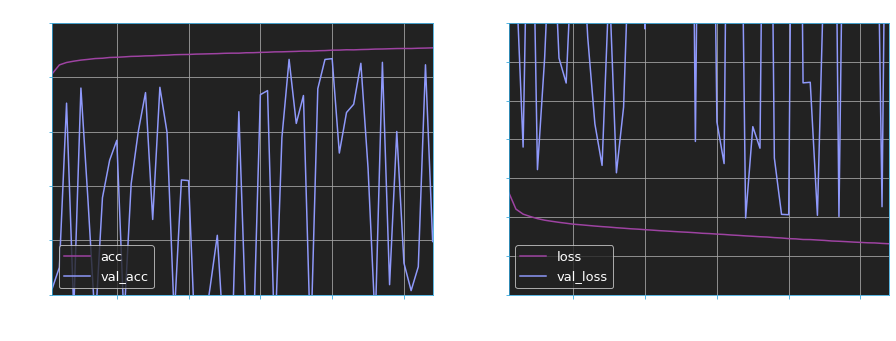

Area under curve for LC EMProb: 0.9381771421693221
Area under curve for flat_EMB1: 0.9418724385628977
Area under curve for resnet: 0.9714048534691564


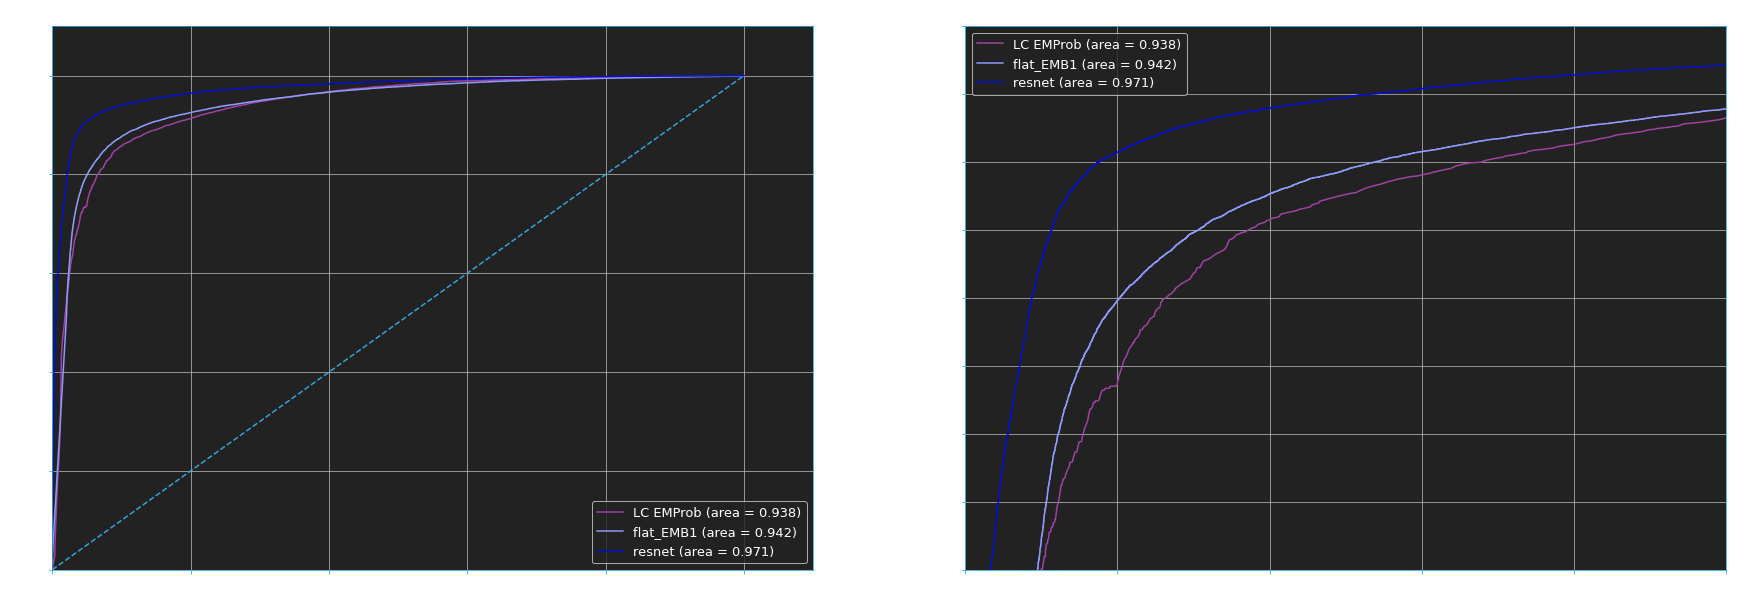

In [22]:
cpu.MetricPlot(
    model_history,
    plotpath=plotpath,
    model_keys=['resnet'],
    plotstyle=plotstyle
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_resnet',
    drawPlots=True,
    plotstyle=plotstyle,
    figsize=(30,10),
    model_keys=['LC EMProb', 'flat_EMB1', 'resnet']
)

## Combination Network: Take 2
<div style="text-align: right"> <a href="#Image-Classification-of-ATLAS-Calorimeter-Topo-Clusters-Rewrite">Top</a> </div>

For fun, we can also train a combination network where we use our ResNet as an additional input.

In [23]:
model_scores_stack = np.column_stack((model_scores_stack, model_scores['resnet']))
n_input = model_scores_stack.shape[1]

nepochs = 50
batch_size = 200*ngpu
verbose = 2


model_name = 'complex'
model_dir = modelpath + model_name # directory for loading/saving ResNet
model_key = 'complexCombine'

lr = 1e-3
gamma = 0.1
min_delta = 0.001
patience = 5

nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts
    
modelfile = '{}/{}{}'.format(model_dir,model_key, file_extension)
models[model_key] = simple_combine_model(strategy, lr=lr, n_input=n_input)
    
# train the network
models[model_key], model_history[model_key] = ctu.TrainNetwork(
    model=models[model_key], 
    modelfile=modelfile, 
    x_train = model_scores_stack[pdata_merged.train],
    y_train = plabels[pdata_merged.train], 
    x_valid = model_scores_stack[pdata_merged.val], 
    y_valid = plabels[pdata_merged.val], 
    callbacks = GetCallbacks(modelfile, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
    epochs=nepochs, 
    batch_size=batch_size, 
    verbose=verbose, 
    overwriteModel=overwriteModel,
    finishTraining=finishTraining
)
        
# get performance metric from test set
model_performance[model_key] = models[model_key].evaluate(
    model_scores_stack[pdata_merged.test],
    plabels[pdata_merged.test],
    verbose=0
)
    
# get/recalculate network scores for the dataset
model_scores[model_key] = models[model_key].predict(model_scores_stack)[:,1]

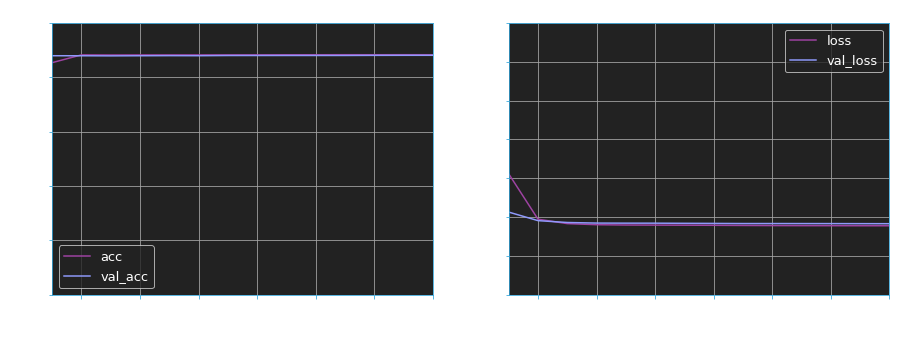

Area under curve for LC EMProb: 0.9381771421693221
Area under curve for simpleCombine: 0.9589334090791628
Area under curve for resnet: 0.9714048534691564
Area under curve for complexCombine: 0.9741778521975413


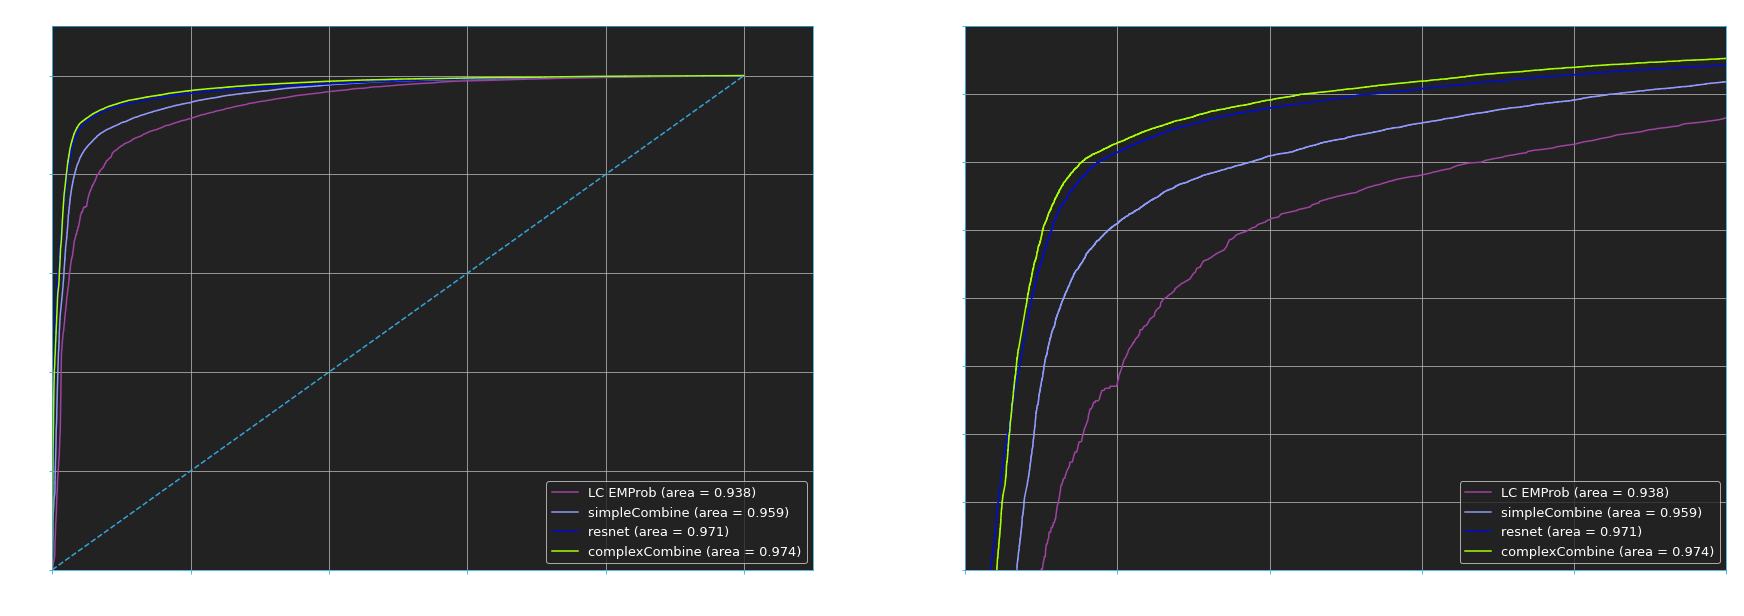

In [24]:
cpu.MetricPlot(
    model_history,
    plotpath=plotpath,
    model_keys = ['complexCombine'],
    plotstyle=plotstyle
)

cpu.RocCurves(
    model_scores,
    data_labels=plabels[:,1],
    indices=pdata_merged.test, 
    roc_fpr=roc_fpr, 
    roc_tpr=roc_tpr, 
    roc_thresh=roc_thresh, 
    roc_auc=roc_auc, 
    plotpath=plotpath,
    plotname='ROC_complex',
    drawPlots=True,
    plotstyle=plotstyle,
    figsize=(30,10),
    model_keys = ['LC EMProb', 'simpleCombine', 'resnet', 'complexCombine']
)